In [187]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Extract data from API

In [188]:
url_api = f"https://api.covidtracking.com/v1/us/daily.json"

In [189]:
response = requests.get(url_api)

In [190]:
# Validate response code
assert(response.status_code == 200)

In [191]:
data = response.json()

df = pd.DataFrame.from_dict(data)

## EDA

In [192]:
df.head()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,lastModified,recovered,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,20210307,56,28756489.0000,74582825.0000,11808.0000,40199.0000,776361.0000,8134.0000,45475.0000,2802.0000,...,2021-03-07T24:00:00Z,None,0,0,842,726,131835,41835,1170059,a80d0063822e251249fd9a44730c49cb23defd83
1,20210306,56,28714654.0000,74450990.0000,11783.0000,41401.0000,775635.0000,8409.0000,45453.0000,2811.0000,...,2021-03-06T24:00:00Z,None,0,0,1680,503,143835,60015,1430992,dae5e558c24adb86686bbd58c08cce5f610b8bb0
2,20210305,56,28654639.0000,74307155.0000,12213.0000,42541.0000,775132.0000,8634.0000,45373.0000,2889.0000,...,2021-03-05T24:00:00Z,None,0,0,2221,2781,271917,68787,1744417,724844c01659d0103801c57c0f72bf8cc8ab025c
3,20210304,56,28585852.0000,74035238.0000,12405.0000,44172.0000,772351.0000,8970.0000,45293.0000,2973.0000,...,2021-03-04T24:00:00Z,None,0,0,1743,1530,177957,65487,1590984,5c549ad30f9abf48dc5de36d20fa707014be1ff3
4,20210303,56,28520365.0000,73857281.0000,11778.0000,45462.0000,770821.0000,9359.0000,45214.0000,3094.0000,...,2021-03-03T24:00:00Z,None,0,0,2449,2172,267001,66836,1406795,fef6c425d2b773a9221fe353f13852f3e4a4bfb0


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      420 non-null    int64  
 1   states                    420 non-null    int64  
 2   positive                  419 non-null    float64
 3   negative                  372 non-null    float64
 4   pending                   369 non-null    float64
 5   hospitalizedCurrently     356 non-null    float64
 6   hospitalizedCumulative    369 non-null    float64
 7   inIcuCurrently            347 non-null    float64
 8   inIcuCumulative           348 non-null    float64
 9   onVentilatorCurrently     348 non-null    float64
 10  onVentilatorCumulative    341 non-null    float64
 11  dateChecked               420 non-null    object 
 12  death                     392 non-null    float64
 13  hospitalized              369 non-null    float64
 14  totalTestR

In [194]:
# Drop columns that are not necessary for a forecasting model - see the API
# documentation for a description of the data
unnecesary_cols = ["recovered", "lastModified", "hash"]

df.drop(unnecesary_cols, axis=1, inplace=True)

In [195]:
# Set the date as index
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

df = df.set_index('date')

In [196]:
df.head()

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,death,hospitalized,totalTestResults,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,
2021-03-07,56,28756489.0000,74582825.0000,11808.0000,40199.0000,776361.0000,8134.0000,45475.0000,2802.0000,4281.0000,...,515151.0000,776361.0000,363825123,0,0,842,726,131835,41835,1170059
2021-03-06,56,28714654.0000,74450990.0000,11783.0000,41401.0000,775635.0000,8409.0000,45453.0000,2811.0000,4280.0000,...,514309.0000,775635.0000,362655064,0,0,1680,503,143835,60015,1430992
2021-03-05,56,28654639.0000,74307155.0000,12213.0000,42541.0000,775132.0000,8634.0000,45373.0000,2889.0000,4275.0000,...,512629.0000,775132.0000,361224072,0,0,2221,2781,271917,68787,1744417
2021-03-04,56,28585852.0000,74035238.0000,12405.0000,44172.0000,772351.0000,8970.0000,45293.0000,2973.0000,4267.0000,...,510408.0000,772351.0000,359479655,0,0,1743,1530,177957,65487,1590984
2021-03-03,56,28520365.0000,73857281.0000,11778.0000,45462.0000,770821.0000,9359.0000,45214.0000,3094.0000,4260.0000,...,508665.0000,770821.0000,357888671,0,0,2449,2172,267001,66836,1406795


In [197]:
df.tail()

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,death,hospitalized,totalTestResults,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,
2020-01-17,1,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
2020-01-16,1,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
2020-01-15,1,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
2020-01-14,1,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
2020-01-13,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


Notice that when they started recolecting data, not all  US states and territories (56) were included.

In [198]:
# Filter the data for all the 56 states and territories
all_states = df[df.states >= 56].copy()

all_states.head()

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,death,hospitalized,totalTestResults,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,
2021-03-07,56,28756489.0000,74582825.0000,11808.0000,40199.0000,776361.0000,8134.0000,45475.0000,2802.0000,4281.0000,...,515151.0000,776361.0000,363825123,0,0,842,726,131835,41835,1170059
2021-03-06,56,28714654.0000,74450990.0000,11783.0000,41401.0000,775635.0000,8409.0000,45453.0000,2811.0000,4280.0000,...,514309.0000,775635.0000,362655064,0,0,1680,503,143835,60015,1430992
2021-03-05,56,28654639.0000,74307155.0000,12213.0000,42541.0000,775132.0000,8634.0000,45373.0000,2889.0000,4275.0000,...,512629.0000,775132.0000,361224072,0,0,2221,2781,271917,68787,1744417
2021-03-04,56,28585852.0000,74035238.0000,12405.0000,44172.0000,772351.0000,8970.0000,45293.0000,2973.0000,4267.0000,...,510408.0000,772351.0000,359479655,0,0,1743,1530,177957,65487,1590984
2021-03-03,56,28520365.0000,73857281.0000,11778.0000,45462.0000,770821.0000,9359.0000,45214.0000,3094.0000,4260.0000,...,508665.0000,770821.0000,357888671,0,0,2449,2172,267001,66836,1406795


In [199]:
# Reorder index
all_states.sort_index(ascending=True, inplace=True)

In [200]:
# Get date range
start_date = all_states.index.min().strftime("%b %d %Y")
end_date = all_states.index.max().strftime("%b %d %Y")

print(f"Start date: {start_date}, End date: {end_date}")

Start date: Mar 16 2020, End date: Mar 07 2021


In [201]:
# Check missing data
all_states.isna().sum()

states                       0
positive                     0
negative                     0
pending                      0
hospitalizedCurrently        1
hospitalizedCumulative       0
inIcuCurrently              10
inIcuCumulative              9
onVentilatorCurrently        9
onVentilatorCumulative      16
dateChecked                  0
death                        0
hospitalized                 0
totalTestResults             0
total                        0
posNeg                       0
deathIncrease                0
hospitalizedIncrease         0
negativeIncrease             0
positiveIncrease             0
totalTestResultsIncrease     0
dtype: int64

In [202]:
all_states.describe().T

,count,mean,std,min,25%,50%,75%,max
states,357.0000,56.0000,0.0000,56.0000,56.0000,56.0000,56.0000,56.0000
positive,357.0000,9526241.4510,8997484.0142,7449.0000,2062186.0000,6346041.0000,15173695.0000,28756489.0000
negative,357.0000,31576657.0308,23746030.2978,20327.0000,8840278.0000,29071387.0000,51940084.0000,74582825.0000
pending,357.0000,9918.0280,9947.0445,960.0000,3645.0000,10118.0000,11986.0000,65698.0000
hospitalizedCurrently,356.0000,57987.1180,31898.5560,325.0000,35100.5000,48811.0000,70519.2500,132474.0000
hospitalizedCumulative,357.0000,321264.3249,232362.3914,43.0000,132345.0000,286686.0000,491491.0000,776361.0000
inIcuCurrently,347.0000,12059.2277,5668.4155,1299.0000,7495.5000,10114.0000,15596.5000,23912.0000
inIcuCumulative,348.0000,21059.3448,13572.6384,74.0000,9900.2500,18797.5000,32998.5000,45475.0000
onVentilatorCurrently,348.0000,3975.2989,2191.0806,167.0000,2168.5000,3186.5000,5828.5000,8004.0000
onVentilatorCumulative,341.0000,2173.9326,1327.3722,32.0000,951.0000,2107.0000,3430.0000,4281.0000


In [203]:
def plot_time_series(column, title):
    """
    Create a time series plot
    """
    df[column].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title=title);

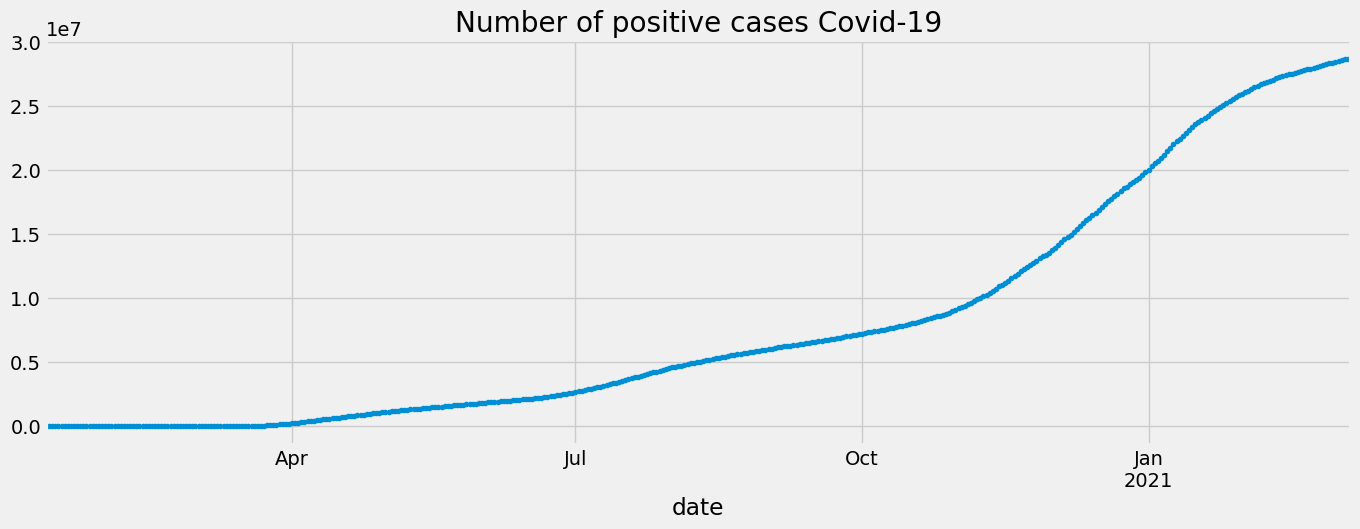

In [204]:
# Plot target
plot_time_series('positive', 'Number of positive cases Covid-19')

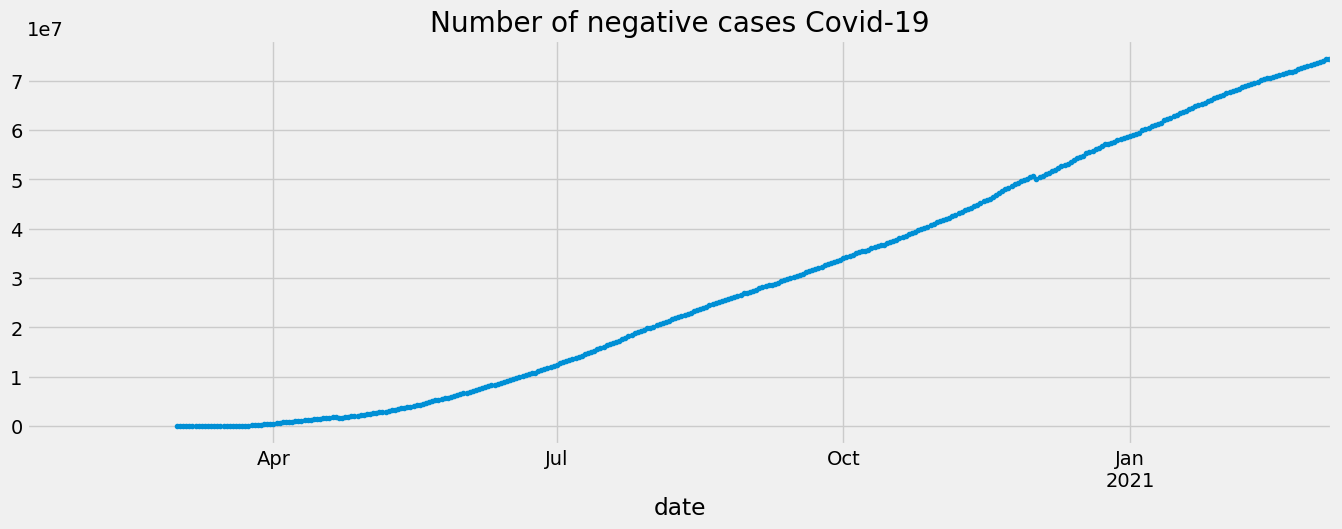

In [205]:
plot_time_series('negative', 'Number of negative cases Covid-19')

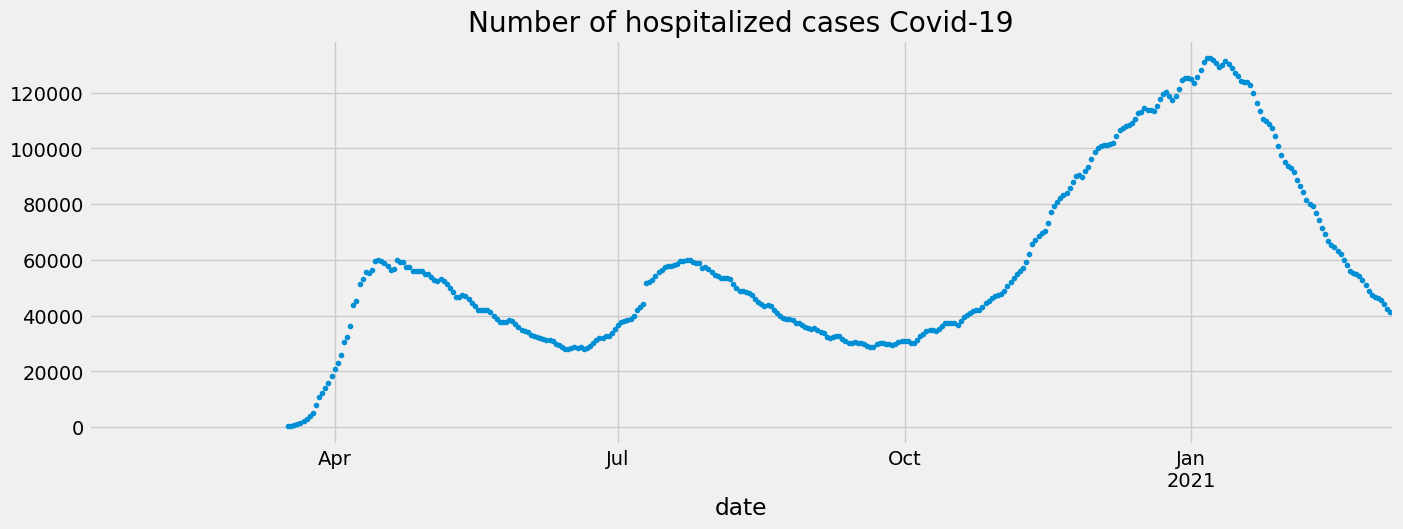

In [206]:
plot_time_series('hospitalizedCurrently', 'Number of hospitalized cases Covid-19')

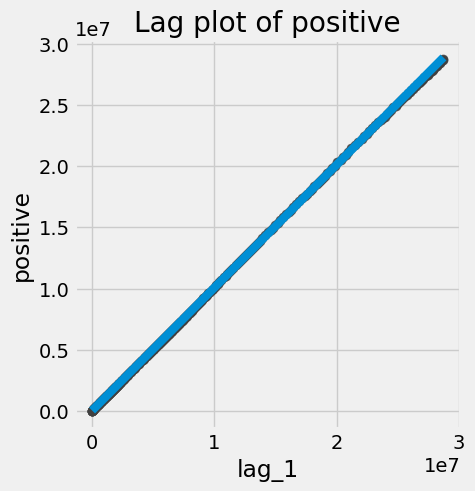

In [207]:
# Use a lag feature
all_states['lag_1'] = all_states['positive'].shift(1)

fig, ax = plt.subplots()
ax = sns.regplot(x='lag_1', y='positive', data=all_states, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag plot of positive');

### Summary EDA

Before deciding which steps we're taking for the preprocessing, we need to take the following into account:

* The order of the data is descending.
* Some features have missing values. However, the missing values are not so many and hence we don't need to impute them. The following features have missing values:
  * hospitalizedCurrently
  * inIcuCurrently
  * inIcuCumulative
  * onVentilatorCurrently
  * onVentilatorCumulative
* When they started recollecting the data, not all states were included.
* It might be worth including time step and lag as features for the model.

## Feature engineering

In [208]:
# Add time step as feature
#all_states['step'] = np.arange(len(all_states.index)).to_frame()

#FEATURES = ['step']
#TARGET = 'positive'

In [209]:
# Use Lag feature
all_states['lag_1'] = all_states['positive'].shift(1)
all_states.dropna(inplace=True)

FEATURES = ['lag_1']
TARGET = 'positive'

## Split data

In [210]:
# Split data for error analysis
X = all_states[FEATURES]
y = all_states.positive

In [211]:
# Split data for training and validating model

train_set, test_set= np.split(all_states[FEATURES + [TARGET]], [int(.80 *len(all_states))])

X_train = train_set[FEATURES]
y_train = train_set[TARGET]

X_test = test_set[FEATURES]
y_test = test_set[TARGET]

## Model selection

In [212]:
model_metrics = []

In [213]:
# Functions for comparing models

RANDOM_STATE = 42

def evaluate_model_rmse(model, X_train, y_train,
                        X_test, y_test):
  """
  Evaluates model using RMSE as a performance metric
  """
  y_pred = model.predict(X_test)
  y_pred_train = model.predict(X_train)

  test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

  return test_rmse, train_rmse


def plot_model_predictions(model, 
                           X,
                           y,
                           title,
                           feature,
                           target,
                           transformation=None):
    """
    Plots predictions vs true values
    """
    plt.scatter(X, y, color='red')
    if transformation:
       X_transformed = transformation.transform(X)
       plt.scatter(X, model.predict(X_transformed), color='blue')
    else:
       plt.plot(X, model.predict(X), color='blue')
    plt.title(title)
    plt.xlabel(feature)
    plt.ylabel(target)

### Linear regression

In [214]:
# Train a simple linear model
lr = LinearRegression()

lr.fit(X_train, y_train)

test_rmse, train_rmse = evaluate_model_rmse(lr, X_train, y_train,
                                            X_test, y_test)

print("Train RMSE: {:.4f}".format(train_rmse))
print("Test  RMSE: {:.4f}".format(test_rmse))

model_metrics.append(('Linear regression', FEATURES[0],
              round(train_rmse, 4), round(test_rmse, 4)))

Train RMSE: 26561.7899
Test  RMSE: 174967.3088


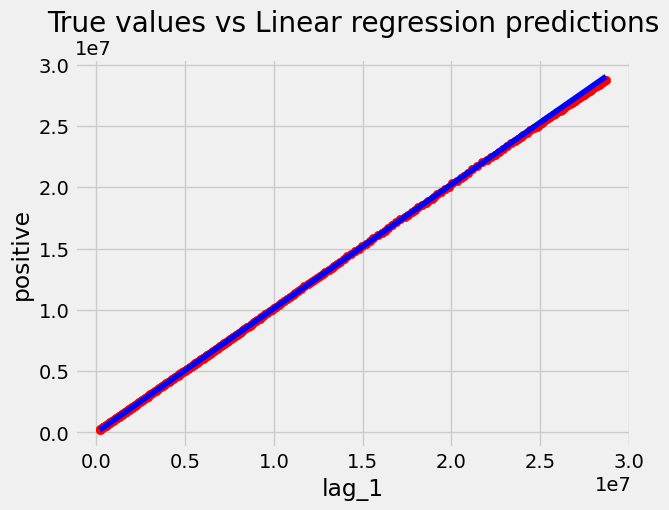

In [215]:
title = 'True values vs Linear regression predictions'
plot_model_predictions(lr, X, y, title, FEATURES[0], TARGET)

### Polynomial regression

In [216]:
poly_reg_features = PolynomialFeatures(degree=2)
X_train_poly = poly_reg_features.fit_transform(X_train)
X_test_poly = poly_reg_features.transform(X_test)

poly_reg = LinearRegression()

poly_reg.fit(X_train_poly, y_train)

test_rmse, train_rmse = evaluate_model_rmse(poly_reg, X_train_poly, y_train,
                                            X_test_poly, y_test)

print("Train RMSE: {:.4f}".format(train_rmse))
print("Test  RMSE: {:.4f}".format(test_rmse))

model_metrics.append(('Polynomial regression degree=2', FEATURES[0],
              round(train_rmse, 4), round(test_rmse, 4)))

Train RMSE: 24858.7770
Test  RMSE: 275486.1795


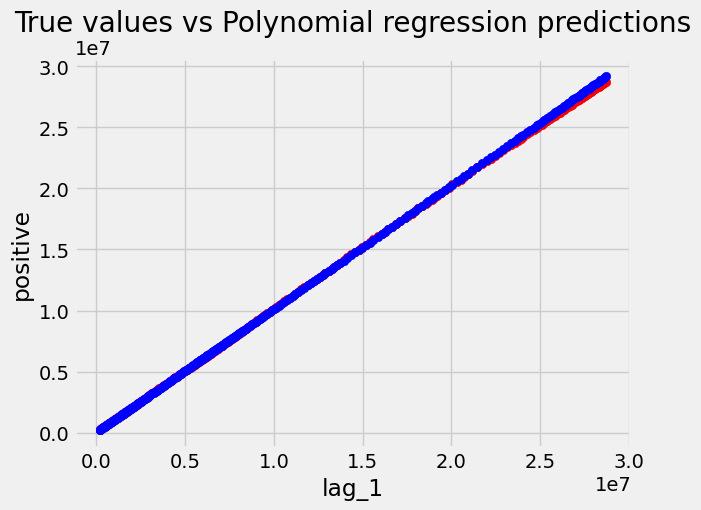

In [217]:
title = 'True values vs Polynomial regression predictions'
plot_model_predictions(poly_reg, X, y, title, 
                       FEATURES[0], TARGET,
                       transformation=poly_reg_features)

### Random forest

In [218]:
rf_reg = RandomForestRegressor(random_state=RANDOM_STATE)

rf_reg.fit(X_train, y_train)

test_rmse, train_rmse = evaluate_model_rmse(rf_reg, X_train, y_train,
                                            X_test, y_test)

print("Train RMSE: {:.4f}".format(train_rmse))
print("Test  RMSE: {:.4f}".format(test_rmse))

model_metrics.append(('Random forest', FEATURES[0],
              round(train_rmse, 4), round(test_rmse, 4)))

Train RMSE: 20020.6858
Test  RMSE: 6821958.9993


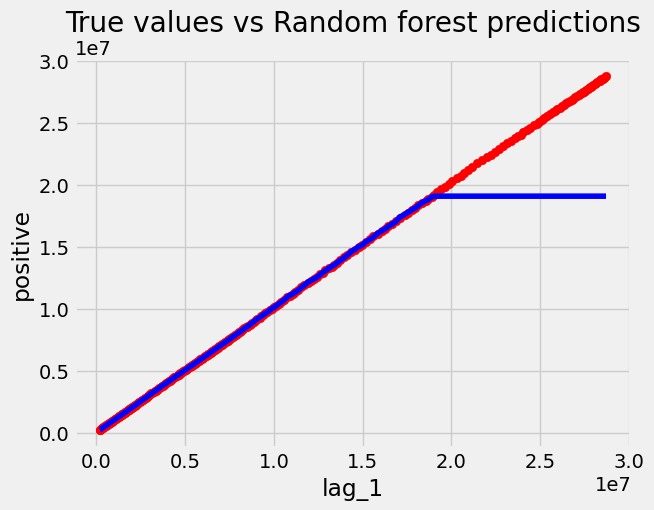

In [219]:
title = 'True values vs Random forest predictions'
plot_model_predictions(rf_reg, X, y, title, 
                       FEATURES[0], TARGET)

The best model so far is linear regression with a lag feature. However, this model is overfitting the data and therefore we need to experiment with regularization.

### Regularization

#### Ridge regression

In [220]:
ridge_reg = Ridge()

ridge_reg.fit(X_train, y_train)

test_rmse, train_rmse = evaluate_model_rmse(ridge_reg, X_train, y_train,
                                            X_test, y_test)

print("Train RMSE: {:.4f}".format(train_rmse))
print("Test  RMSE: {:.4f}".format(test_rmse))

model_metrics.append(('Ridge regression', FEATURES[0],
              round(train_rmse, 4), round(test_rmse, 4)))

Train RMSE: 26561.7899
Test  RMSE: 174967.3088


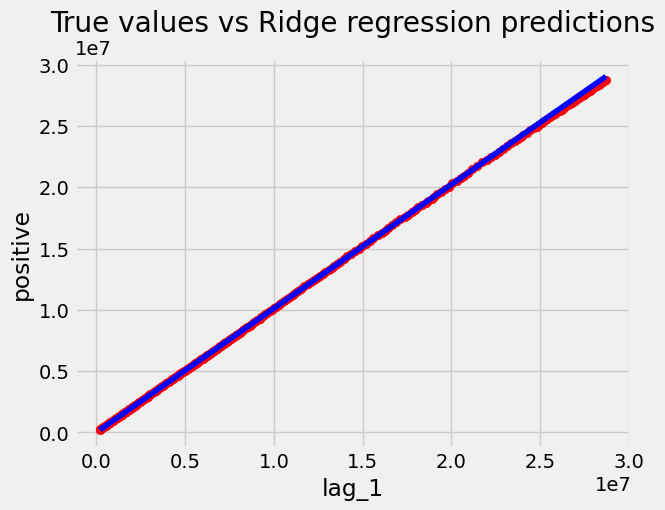

In [221]:
title = 'True values vs Ridge regression predictions'
plot_model_predictions(ridge_reg, X, y, title, 
                       FEATURES[0], TARGET)

### Lasso regression

In [222]:
lasso_reg = Lasso(alpha=0.0001)

lasso_reg.fit(X_train, y_train)

test_rmse, train_rmse = evaluate_model_rmse(lasso_reg, X_train, y_train,
                                            X_test, y_test)

print("Train RMSE: {:.4f}".format(train_rmse))
print("Test  RMSE: {:.4f}".format(test_rmse))

model_metrics.append(('Lasso regression', FEATURES[0],
              round(train_rmse, 4), round(test_rmse, 4)))

Train RMSE: 26561.7899
Test  RMSE: 174967.3088


In [223]:
model_metrics_df = pd.DataFrame(model_metrics, 
                                columns=[
                                    "model",
                                    "feature",
                                    "train_rmse",
                                    "test_rmse"
                                ])

model_metrics_df.head(n=10)

,model,feature,train_rmse,test_rmse
0,Linear regression,lag_1,26561.7899,174967.3088
1,Polynomial regression degree=2,lag_1,24858.7770,275486.1795
2,Random forest,lag_1,20020.6858,6821958.9993
3,Ridge regression,lag_1,26561.7899,174967.3088
4,Lasso regression,lag_1,26561.7899,174967.3088


As we can see, using regularization doesn't fix the overfitting problem. However, the best model so far is linear regression with a lag feature (train and test error are the ones that are closer than the rest).

## Explainability

In [228]:
# Print the winning model's coefficients

pd.DataFrame([(X.columns, lr.coef_, lr.intercept_)])

,0,1,2
0,"Index(['lag_1'], dtype='object')",[1.0110869074716322],3347.2360


The number of positive caes tend to mutiply by 1.011087 on average every day.